# Exercise 4.3: Independent Component Analysis in Practice


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA

## Blind Source Separation using FastICA

Imagine the following situation: there are three singers in a sound studio. Each of the singers ("sound source") generates a sound wave $s_{i}(t)$ over time $t$. The singers are surrounded by three microphones while each of those are recording the arriving sound $x_{j}(t)$. Given the observations of the three microphones $x_{j}(t), j=\{1,2,3\}$, we now want to compute a reconstruction of the contribution of each singer $s_{i,rec}(t)$ using an ICA model.

__Note:__ In the following code, the true sources $S_{true}$ as well as the mixing matrix $A$ are given to generate the observations $X$. In a real world scenario, this would of course not be the case. Instead, you want to reconstruct the independent sources $S_{rec}$ and the mixing matrix $\hat A$.

__Tasks:__
1. Inspect the given generative model for constructing a data set of the above described scenario and train a FastICA model in order to reconstruct $s_{i,rec}(t)$ of each singer. Therefore, you can use the FastICA implementation of the scikit-learn toolbox. 
2. Visualize the observations $x_{j}(t)$ of every microphone, the reconstructed source signals $s_{i,rec}(t)$ and the true sources for all three components $s_{i,true}(t)$. Therefore, use the function 'visualize_data()' as you need to do such kind of plots a few times within this exercise.
3. Plot histograms of the estimated sources. 

In [2]:
def visualize_data(models, names):
    '''plot figure with subplot for each specified model, 
    in each subplot all three components are shown
    Input: list 'models', 'names' 
           (e.g. models = [X, S_true] and names =['observations X', 'true sources'])'''
    
    colors = ['red', 'skyblue', 'orange']
    
    plt.figure(figsize=(12,8))
    for ii, (model, name) in enumerate(zip(models, names), 1):
        plt.subplot(len(names), 1, ii)
        plt.title(name,fontsize=15)
        for sig, color in zip(model.T, colors):
            plt.plot(sig+ii*2*max(sig), color=color)
        
    plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
    plt.show()

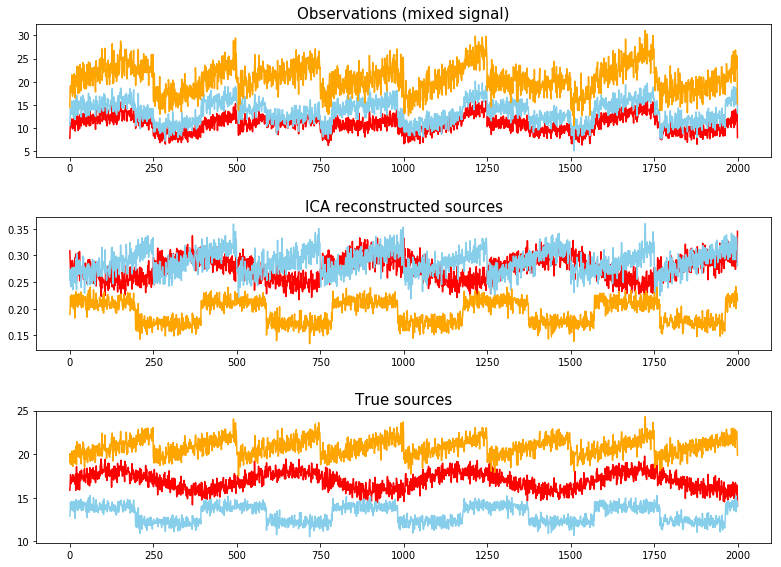

In [3]:
# Generate sample data
np.random.seed(35)
N_samples = 2000
time = np.linspace(0, 8, N_samples)

# Singer 1 : sinusoidal signal
s1 = np.sin(3 * time)  
# Singer 2 : square signal
s2 = np.sign(np.sin(4 * time))
# Singer 3: saw tooth signal
s3 = signal.sawtooth(2 * np.pi * time)  

# concatenate the true single sources and add noise 
S_true = np.c_[s1, s2, s3]
S_true += 0.5 * np.random.normal(size=S_true.shape)  

# standardize the data
S_true /= S_true.std(axis=0) 

# Mix data
A = np.array([[1, 1, 1], [0.3, 2, 1.2], [1.5, 1.2, 2.4]])  # Mixing matrix
X = np.dot(S_true, A.T)

# Task (1): Compute ICA with three components and reconstruct signals from the observations
ica = FastICA(n_components=3)
S_rec = ica.fit_transform(X)  

# Task (2): Plot the observations X, the true source S_true and the reconstructed sources S_rec
models = [X, S_rec, S_true]

names = ['Observations (mixed signal)',
         'ICA reconstructed sources',
         'True sources']

visualize_data(models,names)

#### Q4.3.1) Compare the time series of the reconstructed sources with the true sources in terms of their order and sign. What do you observe?

__Answer__: Signs, magnitude and order of the independent components are different in some cases. The reason for this is discussed in Exercise 4b.1.3. 

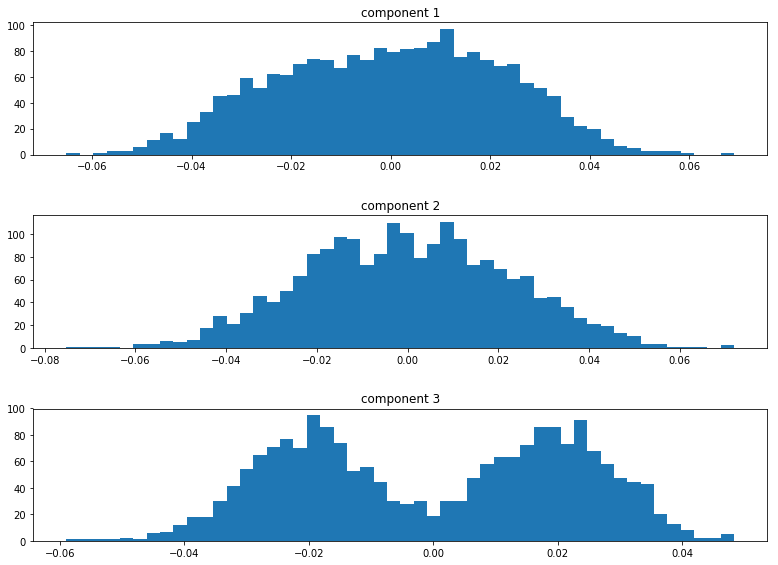

In [4]:
# Task (3): Visualize the histogram of all three estimated independent components

plt.figure(figsize=(12,8))
for col_idx in range(S_rec.shape[1]):   
    plt.subplot(3,1,col_idx+1)
    plt.title('component %i' % (col_idx+1))
    plt.hist(S_rec[:,col_idx],50)
    
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

#### Q4.3.2) Verify the distribution of the estimated independent components. Which types of distributions do you expect the ICA to return?

__Answer__: As the ICA model maximizes non-gaussianity of the independent sources, this is reflected in the histograms of the estimated independent components. 

## Influence of data shuffling 

Now, we assume that the time information $t$ of the studio recording gets lost and verify the influence upon the ICA model.  

__Tasks:__ 
1. Generate a time-shuffled version of the observations $X_{shuffled}$. __Hint:__ You can use the `np.random.permutation()` function to generate a permutation of timesteps $\{1, 2, ..., T\}$, which can be used to rearrange your dataset along one axis.
2. Compute an ICA model on the modified recordings $X_{shuffled}$ and un-shuffle the reconstructed independent sources $S_{rec,shuffled}$ such that it has the same temporal order as $S_{true}$. __Hint:__ You can use the `np.argsort()` function to invert the permutation you generated before.
3. Use the 'visualize_data()' function to plot the reconstructed, unshuffled ICA-sources $S_{rec}$ and the true sources $S_{true}$.

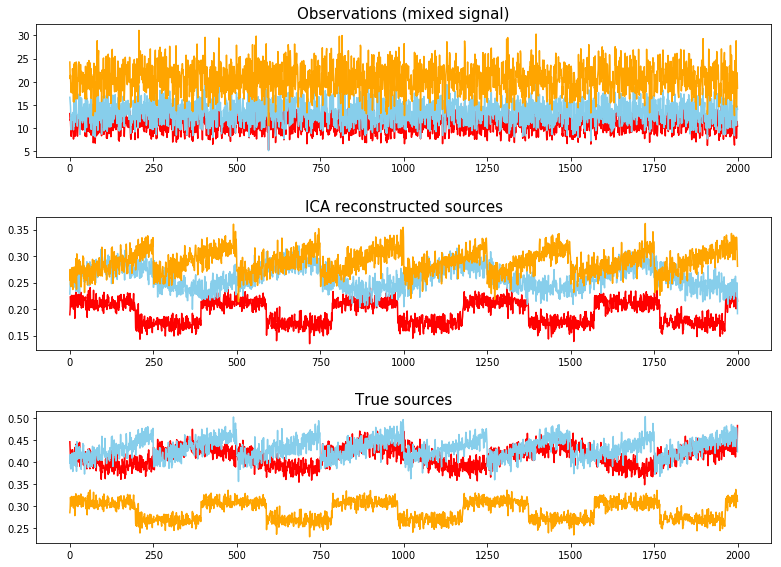

In [5]:
# Task (1): Randomly shuffle X
rand_order = np.random.permutation(N_samples)
rand_order_reverse = np.argsort(rand_order)
X_shuffled = np.dot(S_true, A.T)[rand_order] 

# Task (2): Re-Train ICA model on X_shuffled and un-shuffle the reconstructed sources 
S_rec_shuffled = ica.fit_transform(X_shuffled)
S_rec_reshuf = S_rec_shuffled[rand_order_reverse]

# Task (3): Visualize the different signals
models = [X_shuffled, S_rec_reshuf, S_rec]
names = ['Observations (mixed signal)',
         'ICA reconstructed sources',
         'True sources']

visualize_data(models,names)

#### Q4.3.3) Compare the reconstructed ICA-sources for the shuffled data and the non-shuffled data - can you give a reason for your observation?

__Answer:__ The reconstructed sources are the same (except for sign and order) for the shuffled and non-shuffled data. The ICA algorithm assumes that each observation $x_j$ as well as each ICA component $s_k$ are random variables. Thus, the algorithm only considers the distribution of the random variables, the temporal structure of the data is omitted.
__Remark:__ There are ICA variants that take temporal information into account to improve blind source separation of time series. See __[1](https://ieeexplore.ieee.org/document/554307/)__ and __[2](https://link.springer.com/chapter/10.1007/978-1-4471-1599-1_103)__ 

## Remove ICA component from your observations

Now, we want to remove the contribution of two singers from the studio recordings $X$ such that only the contribution of singer 1 (sinusoidal waveform) remains. Therefore, you need to do the following steps:

__Tasks:__
1. Take the unmixing matrix $W=\hat A^{-1}$ of the component/s you want to keep and project the observation data $X$ to the  source space $S_{est}$
2. Use the estimated mixing matrix $\hat A$ of the component/s you want to keep and project the reconstructed sources $S_{est}$ back to the observation space $X_{clean}$. 
3. Visualize the cleaned observations $X_{clean}$, the original observations $X$ as well as the reconstructed sources $S_{est}$.

__Hint:__ When selecting the components you want to remove from the observations, it might help to iteratively look at the cleaned observations $X_{clean}$ in order to see the effect.

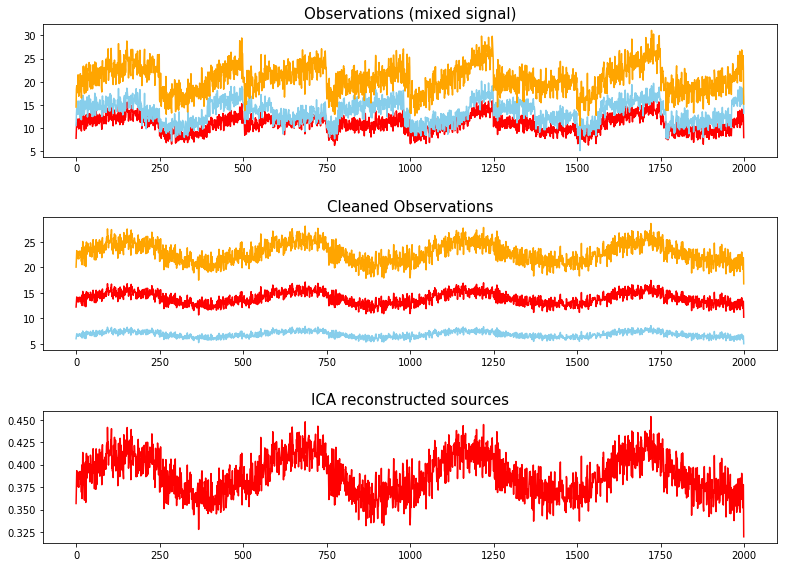

In [7]:
# Task (1): Project data of selected components to the source space, using the unmixing matrix
S_est = np.dot(X, ica.components_[[1],:].T)

# Task (2): Project reconstructed ICA sources to the original space by mixing matrix 
X_clean = np.dot(S_est,ica.mixing_[:,[1]].T) 

# Task (3): Visusalize the time series data
models = [X, X_clean, S_est]
names = ['Observations (mixed signal)',
         'Cleaned Observations',
         'ICA reconstructed sources']

visualize_data(models,names)

#### Q4.3.4) Revisit the 'ML design cycle' referred to in the lecture. To which block would you assign the removal of an ICA component? 

__Answer:__ Removing an ICA component from a dataset can be done in order to preprocess your features that you would use for a ML problem. 
